In [1]:
# import os
# # Set working directory manually on Gadi to be able to load csv files
# user = os.getenv('USER')
# os.chdir('/scratch/cd82/'+user+'/notebooks/')


# 🏡 Random Forest Classification with Heart Disease Dataset

## What is Bagging?

**Bagging** (Bootstrap Aggregation) is an ensemble learning technique that helps reduce variance by training multiple models on different subsets of the data (with replacement) and combining their outputs. This makes the final model more robust and stable.

## What is a Random Forest?

**Random Forest** is an ensemble of decision trees built using bagging. Each tree is trained on a random subset of the data and a random subset of features. The final prediction is made by majority vote (classification) or average (regression).

Random Forests are powerful, easy to use, and work well on many real-world problems.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import shap

df = pd.read_csv("heart.csv")
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## 🔧 Key Hyperparameters in Random Forest

We'll explore the effect of the following hyperparameters:

1. `n_estimators`: Number of trees in the forest.
2. `max_depth`: Maximum depth of each tree.
3. `min_samples_split`: The minimum number of samples required to split an internal node.

Let's see how each of these affects performance!


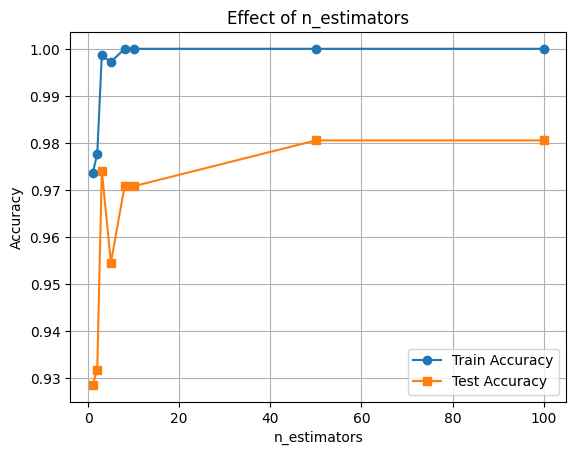

In [3]:

n_vals = [1, 2, 3 ,5 ,8, 10, 50, 100]
train_scores = []
test_scores = []

for n in n_vals:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot(n_vals, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_vals, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Effect of n_estimators')
plt.legend()
plt.grid(True)
plt.show()


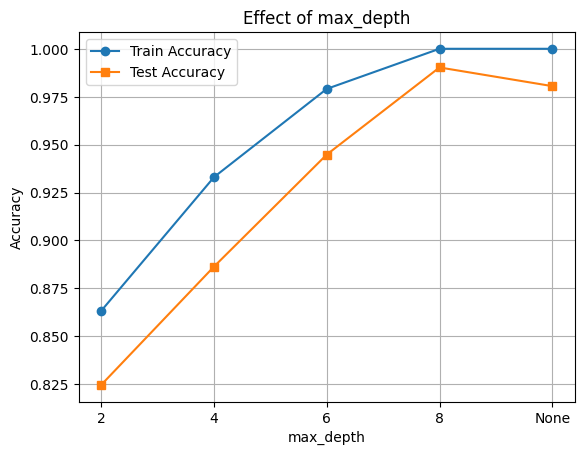

In [4]:

depths = [2, 4, 6, 8, None]
train_scores, test_scores = [], []

for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot([str(d) for d in depths], train_scores, marker='o', label='Train Accuracy')
plt.plot([str(d) for d in depths], test_scores, marker='s', label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth')
plt.legend()
plt.grid(True)
plt.show()


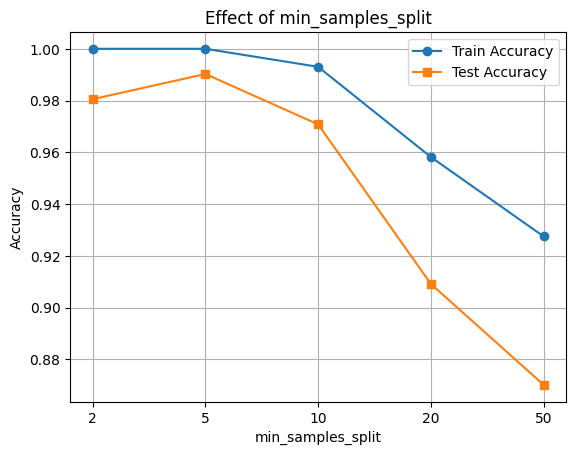

In [5]:
# Evaluate RandomForestClassifier performance with varying min_samples_split
splits = [2, 5, 10, 20, 50]
train_scores, test_scores = [], []

for s in splits:
    clf = RandomForestClassifier(min_samples_split=s, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot([str(s) for s in splits], train_scores, marker='o', label='Train Accuracy')
plt.plot([str(s) for s in splits], test_scores, marker='s', label='Test Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_split')
plt.legend()
plt.grid(True)
plt.show()



## 🔍 Feature Importance with SHAP

Now let's interpret the model using **SHAP values** to see which features were most influential.


In [6]:
final_clf = RandomForestClassifier(n_estimators=100, max_depth=8, max_features='sqrt', random_state=42)
final_clf.fit(X_train, y_train)

# Accuracy
train_acc = final_clf.score(X_train, y_train)
test_acc = final_clf.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Train Accuracy: 1.000
Test Accuracy: 0.990


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       159
           1       1.00      0.98      0.99       149

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



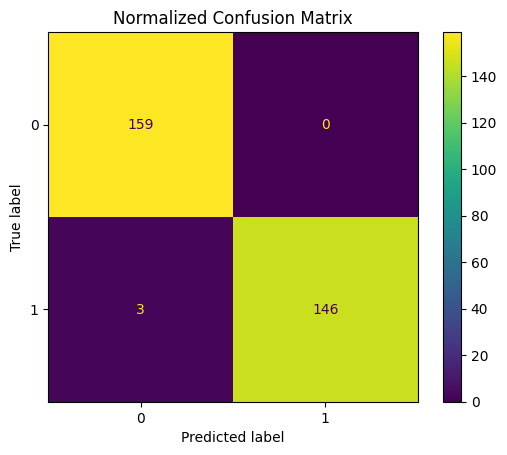

In [7]:

y_pred = final_clf.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(final_clf, X_test, y_test)
plt.title("Normalized Confusion Matrix")
plt.show()


## 🧠 Feature Importance with SHAP

We'll use SHAP (SHapley Additive exPlanations) to understand how different features contribute to the model's predictions.

This helps us:
- Identify the most influential features
- Understand direction and magnitude of impact


### 📊 Interpreting the SHAP Summary Plot

The SHAP summary plot visualizes how each feature contributes to the model's output across all samples. Here's what each component means:

| Element                      | Description                                                                                      |
|-----------------------------|--------------------------------------------------------------------------------------------------|
| **Y-axis (Feature Names)**  | Features are sorted by overall importance (top = most important).                              |
| **X-axis (SHAP value)**     | The impact of that feature on the model's prediction.                                           |
| **Each Dot**                | A single row/sample in the dataset.                                                             |
| **Color (Dot Hue)**         | The feature value for that sample — red = high, blue = low.                                    |
| **Direction of SHAP Value**| Positive SHAP value pushes the prediction toward the positive class (e.g., "disease" class).    |
|                             | Negative SHAP value pushes it toward the negative class (e.g., "no disease").                   |

**🧠 Example Interpretation:**  
If the “Age” feature has mostly red dots (high values) with positive SHAP values, it means higher ages are pushing predictions toward the positive class.


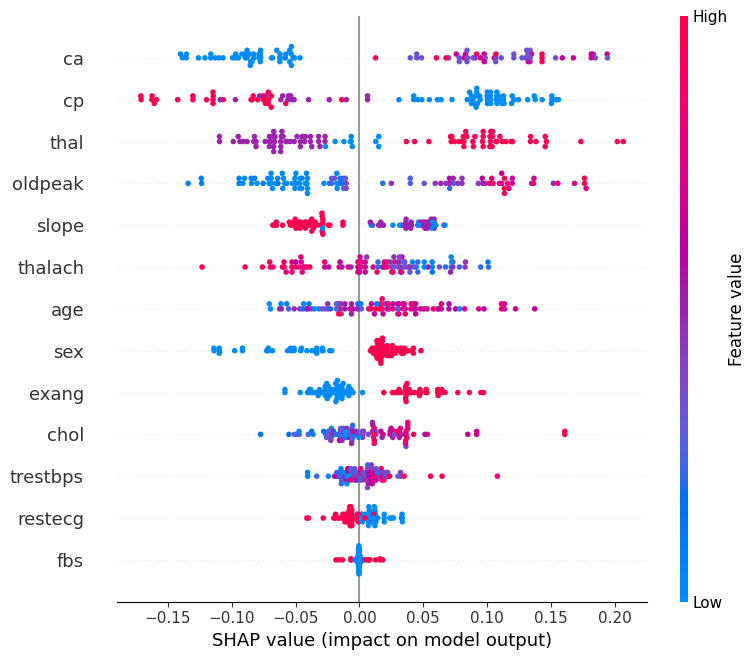

In [8]:
import shap

explainer = shap.TreeExplainer(final_clf, X_train)

n_datapoints = 100
shap_values = explainer.shap_values(X_test[:n_datapoints])

class_index = 0
shap.summary_plot(shap_values[:, :, class_index], X_test[:n_datapoints])